In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

plt.style.use("fivethirtyeight")

In [2]:
df = pd.read_csv("a_b_testing_conversion_updated_2.csv")
df = df.set_index("visit_id")
df.head()

,segments,converted
visit_id,,
89d04554-8512-4dcb-8437-b0e348b1a04d,meiro_family_b_quality_watcher,True
8c0f41a5-2d51-420b-bdaa-078232fa1058,meiro_family_a_quality_watcher,True
08112bb9-883e-40c9-a150-f64ee515754b,meiro_family_b_quality_watcher,True
3a8fd258-0b2d-40bb-aaa5-b7236505345b,meiro_family_b_quality_watcher,True
1e7627f8-c974-477c-90e8-21afc1915af9,meiro_family_b_quality_watcher,True


In [3]:
df["segments"].value_counts()

meiro_family_a_quality_watcher    372039
meiro_family_b_quality_watcher    371845
Name: segments, dtype: int64

In [4]:
df.reset_index().groupby("segments").agg(lambda x: x.nunique())["visit_id"]

segments
meiro_family_a_quality_watcher    358370
meiro_family_b_quality_watcher    358617
Name: visit_id, dtype: int64

In [5]:
df[df["converted"] == True]["segments"].value_counts()

meiro_family_a_quality_watcher    208230
meiro_family_b_quality_watcher    207419
Name: segments, dtype: int64

In [6]:
sampled_df = df.reset_index(drop=True)
sampled_df.head()

,segments,converted
0,meiro_family_b_quality_watcher,True
1,meiro_family_a_quality_watcher,True
2,meiro_family_b_quality_watcher,True
3,meiro_family_b_quality_watcher,True
4,meiro_family_b_quality_watcher,True


In [7]:
# sampled_df = df.groupby("segments").apply(lambda x: x.sample(df["segments"].value_counts().min())).reset_index(drop=True)

In [8]:
# sampled_df["segments"].value_counts()

In [9]:
# sampled_df[sampled_df["converted"] == True]["segments"].value_counts()

In [10]:
%%time

random_state = 42
num_times = 1000
all_df = []

for num in range(num_times):
    sampled_segments = sampled_df[["segments"]].sample(frac=1, random_state=random_state + num).reset_index(drop=True)
    sampled_segments["converted"] = sampled_df["converted"]
    all_df.append(sampled_segments)

CPU times: total: 1min 4s
Wall time: 1min 41s


In [11]:
%%time

list_a, list_b = [], []

for i in range(len(all_df)):
    list_a.append(len(all_df[i][(all_df[i]["converted"] == True) & (all_df[i]["segments"] == "meiro_family_a_quality_watcher")]))
    list_b.append(len(all_df[i][(all_df[i]["converted"] == True) & (all_df[i]["segments"] == "meiro_family_b_quality_watcher")]))

CPU times: total: 1min 12s
Wall time: 3min 41s


In [12]:
summary = pd.DataFrame({
    "visit": df.reset_index().groupby("segments").agg(lambda x: x.nunique())["visit_id"].values,
    "conversion": sampled_df[sampled_df["converted"] == True]["segments"].value_counts().values
})
summary["conversion_rate"] = summary["conversion"] / summary["visit"] * 100
summary.index = np.sort(sampled_df["segments"].unique())
summary

,visit,conversion,conversion_rate
meiro_family_a_quality_watcher,358370,208230,58.104752
meiro_family_b_quality_watcher,358617,207419,57.838585


In [58]:
a_conversion_rate = summary["conversion_rate"].loc["meiro_family_a_quality_watcher"]
b_conversion_rate = summary["conversion_rate"].loc["meiro_family_b_quality_watcher"]

difference = abs(((b_conversion_rate - a_conversion_rate) / a_conversion_rate) * 100)
difference

0.4580806349099833

In [131]:
simulation_df = pd.DataFrame({
    "a_converted": list_a,
    "b_converted": list_b
})

simulation_df["combined"] = simulation_df.apply(lambda row: f'a: {row["a_converted"]}\nb: {row["b_converted"]}', axis=1)
simulation_df["difference"] = abs(((simulation_df["b_converted"] - simulation_df["a_converted"]) / simulation_df["a_converted"]) * 100)
simulation_df["threshold"] = simulation_df["difference"] >= difference
simulation_df["color"] = simulation_df["threshold"].apply(lambda x: "red" if x else "blue")

simulation_df = simulation_df.sort_values(by=["a_converted", "b_converted"], ascending=[True, False])
simulation_df.head()

,a_converted,b_converted,combined,difference,threshold,color
462,207231,208418,a: 207231\nb: 208418,0.572791,True,red
111,207234,208415,a: 207234\nb: 208415,0.569887,True,red
974,207270,208379,a: 207270\nb: 208379,0.535051,True,red
604,207337,208312,a: 207337\nb: 208312,0.470249,True,red
702,207340,208309,a: 207340\nb: 208309,0.467348,True,red


In [132]:
p_value = len(simulation_df[simulation_df["threshold"] == True]) / len(simulation_df) * 100
p_value

3.0

In [133]:
100 - p_value

97.0

In [139]:
simulation_df = pd.DataFrame({
    "a_converted": list_a,
    "b_converted": list_b
})

simplified = 10
simulation_df["a_converted"] = simulation_df["a_converted"] // simplified * simplified
simulation_df["b_converted"] = simulation_df["b_converted"] // simplified * simplified

simulation_df["combined"] = simulation_df.apply(lambda row: f'a: {row["a_converted"]}\nb: {row["b_converted"]}', axis=1)
simulation_df["difference"] = abs(((simulation_df["b_converted"] - simulation_df["a_converted"]) / simulation_df["a_converted"]) * 100)
simulation_df["threshold"] = simulation_df["difference"] >= difference
simulation_df["color"] = simulation_df["threshold"].apply(lambda x: "#ff0000" if x else "#008fd5")

simulation_df = simulation_df.sort_values(by=["a_converted", "b_converted"], ascending=[True, False])
simulation_df.head()

,a_converted,b_converted,combined,difference,threshold,color
111,207230,208410,a: 207230\nb: 208410,0.569416,True,#ff0000
462,207230,208410,a: 207230\nb: 208410,0.569416,True,#ff0000
974,207270,208370,a: 207270\nb: 208370,0.530709,True,#ff0000
604,207330,208310,a: 207330\nb: 208310,0.472676,True,#ff0000
404,207340,208300,a: 207340\nb: 208300,0.463008,True,#ff0000


In [140]:
distribution = pd.DataFrame(simulation_df["combined"].value_counts()).reindex(simulation_df["combined"].unique())
distribution["color"] = list(simulation_df.drop_duplicates()["color"])
distribution

,combined,color
a: 207230\nb: 208410,2,#ff0000
a: 207270\nb: 208370,1,#ff0000
a: 207330\nb: 208310,1,#ff0000
a: 207340\nb: 208300,2,#ff0000
a: 207360\nb: 208280,4,#008fd5
...,...,...
a: 208430\nb: 207210,1,#ff0000
a: 208440\nb: 207200,1,#ff0000
a: 208450\nb: 207190,2,#ff0000
a: 208470\nb: 207170,2,#ff0000


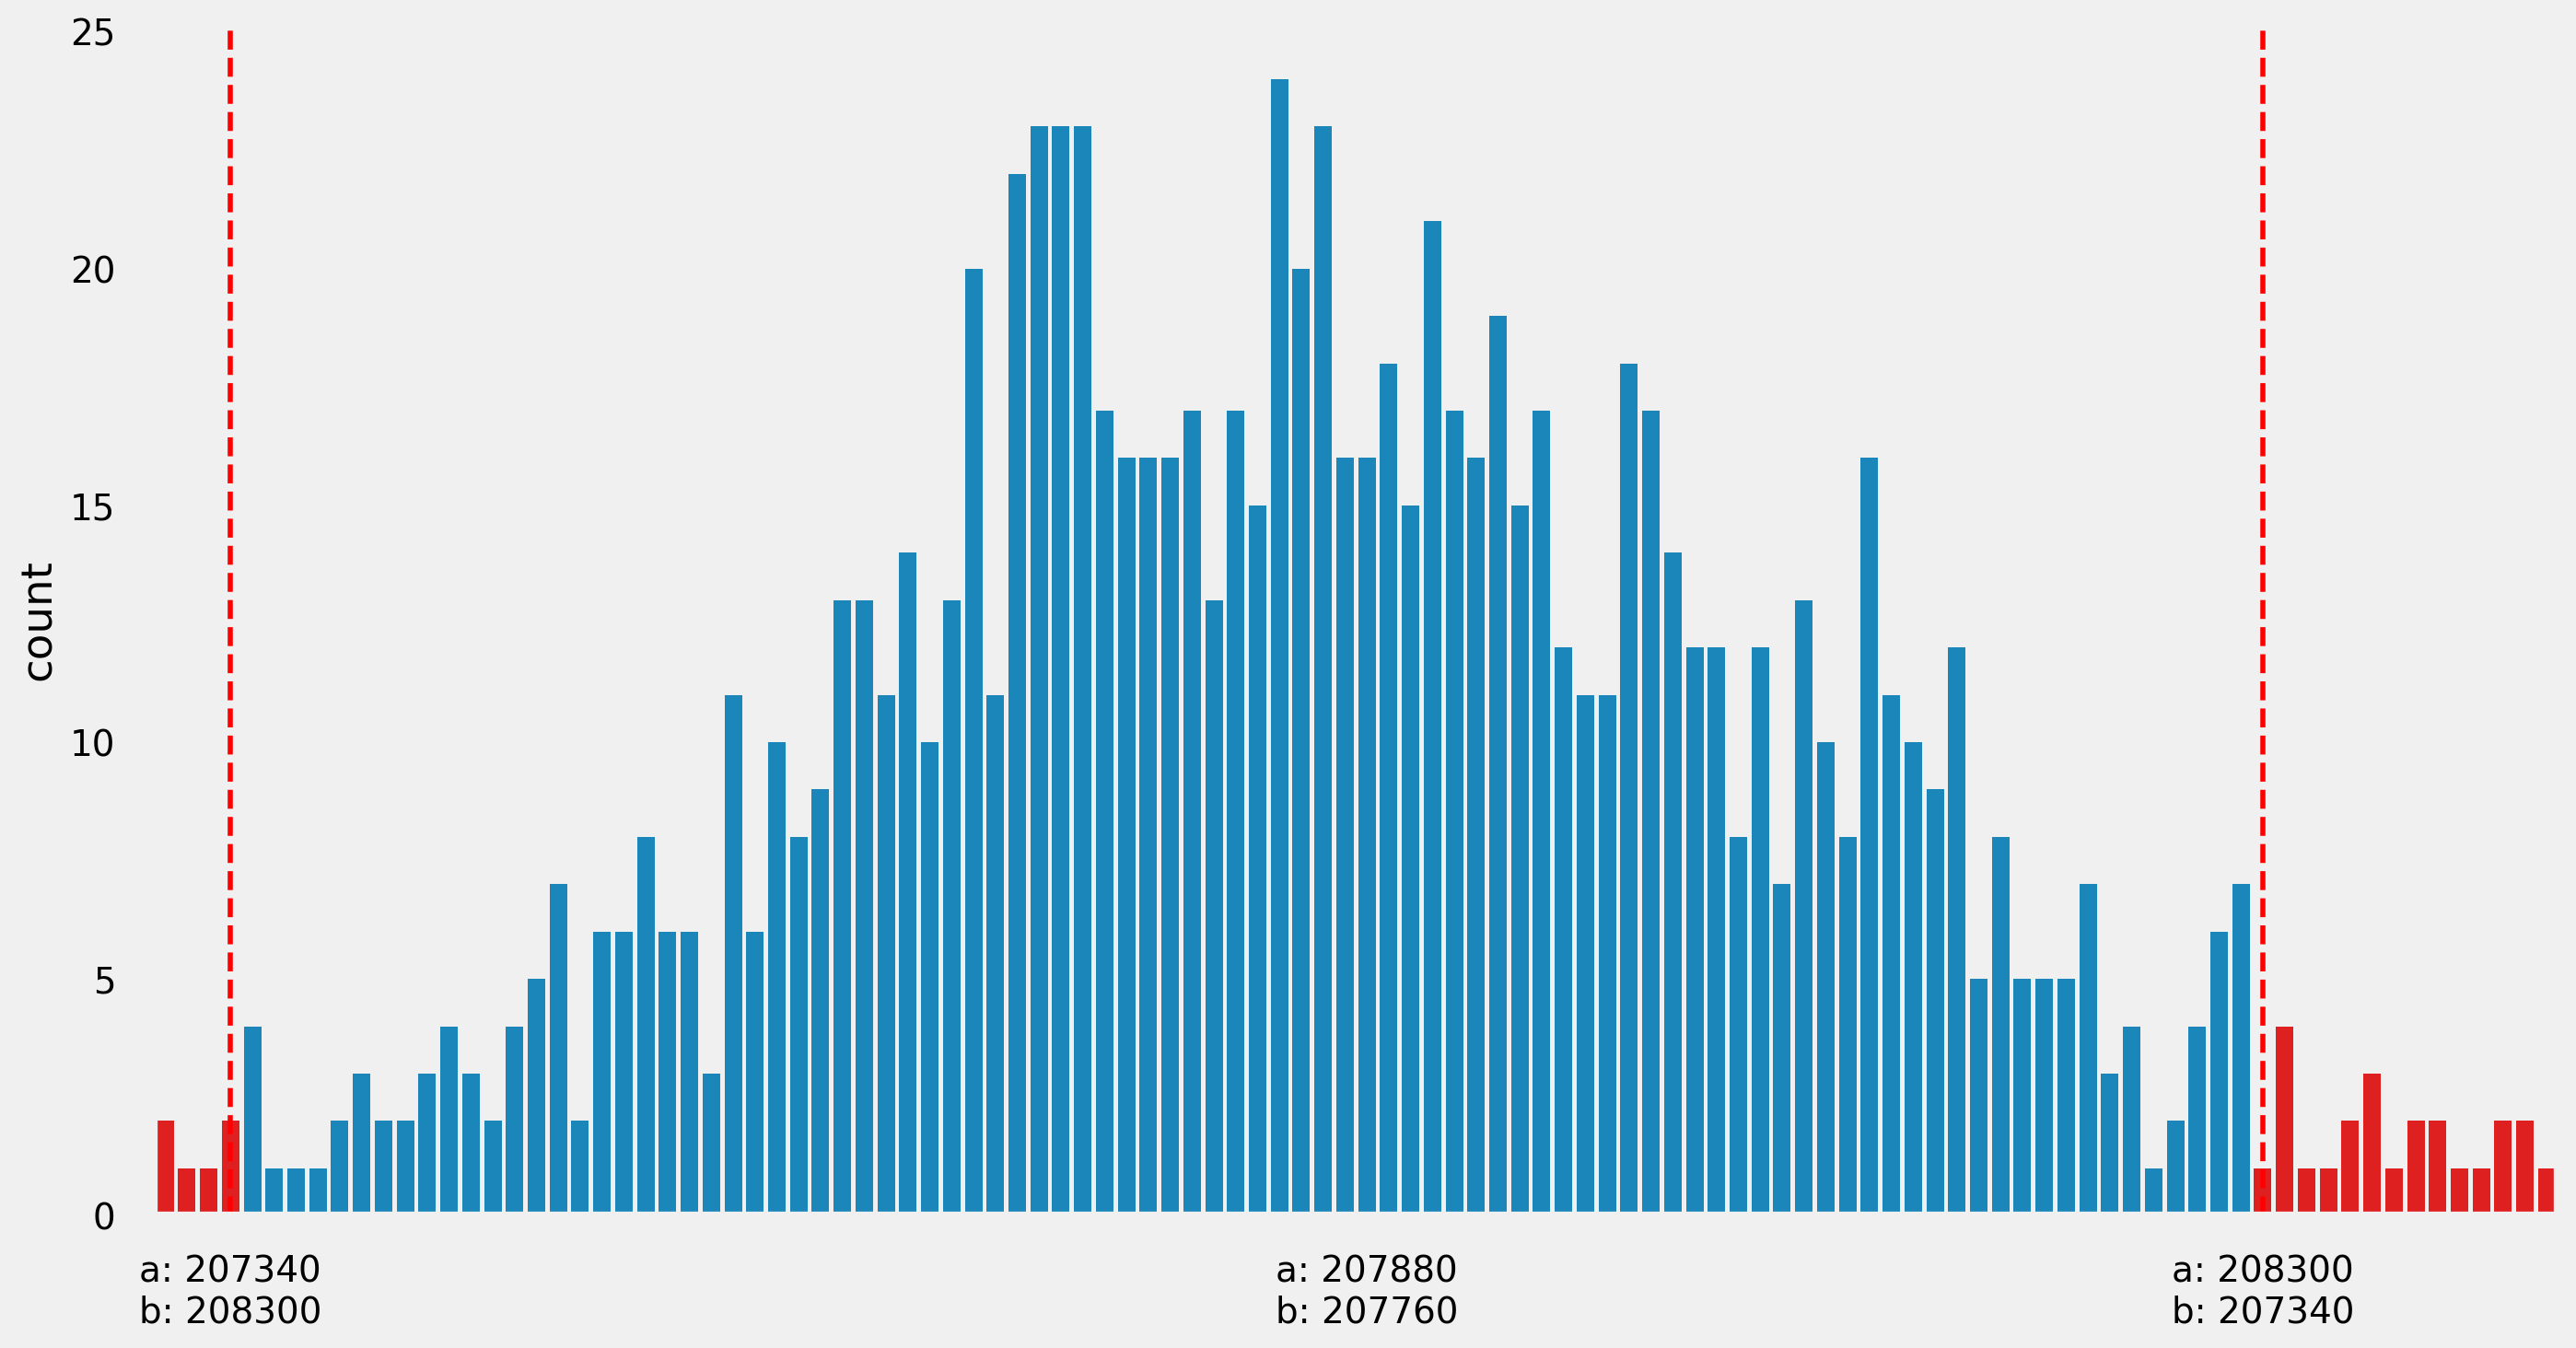

In [154]:
fig, ax = plt.subplots(figsize=(15, 8), dpi=200)
count = sns.countplot(data=simulation_df, x="combined", ax=ax, order=simulation_df["combined"].unique(), palette=list(simulation_df.drop_duplicates()["color"]))
    
xtick_labels = ax.get_xticklabels()
xtick_labels_text = [label.get_text() for label in xtick_labels]
vertical_lines_xticks = ["a: 207340\nb: 208300", "a: 208300\nb: 207340"]
vertical_lines_indices = [xtick_labels_text.index(label) for label in vertical_lines_xticks]
for index in vertical_lines_indices:
    ax.axvline(x=index, color="#ff0000", linestyle="--", linewidth=2)
    
center_index = len(xtick_labels_text) // 2
desired_xticks_indices = vertical_lines_indices + [center_index]
ax.set_xticks(desired_xticks_indices)
ax.set_xticklabels([xtick_labels_text[index] for index in desired_xticks_indices])

ax.set_xlabel("")
ax.tick_params(axis="x", which="both", pad=15)
ax.tick_params(axis="y", which="both", pad=15)
    
ax.grid(False)
plt.show()

In [124]:
vertical_lines_indices

[3, 96]